In [1]:
%matplotlib inline
import math
import pprint

import numpy as np
from sklearn.neighbors import NearestNeighbors
# from pyts.approximation import SymbolicAggregateApproximation
from saxpy.znorm import znorm
from saxpy.paa import paa
import pandas as pd
import seaborn as sns
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from datetime import datetime

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
class ErrorDetection:
    def __init__(self, time_series, k=None, c=None, v=None):
        self.time_series = time_series
        self.time_series_values = self.time_series[:, 1]
        self.candidate_scores = {}  # index of candidate point --> [MS, CS, VS]
        # After the clustering, it would be index --> [MS, CS, VS, Label]
        self.knn = {}  # k --> result of running KNN for specified k
        self.k = k
        self.c = c
        self.v = v

    def compute_scores(self, candidate_points):
        for i in tqdm(range(len(candidate_points))):
            point_index = candidate_points[i]
            magnitude_score, inn_set = self.compute_magnitude_score(point_index)
            # correlation_score = self.compute_correlation_score(inn_set, candidate_points)
            correlation_score = 0
            variance_score = self.compute_variance_score(inn_set, point_index)
            self.candidate_scores[point_index] = [magnitude_score, correlation_score, variance_score]

    def compute_magnitude_score(self, point_index):
        # point_inn = self.compute_inn(time_series, point[0])
        point_inn = self.compute_inn(self.time_series_values, point_index)
        return len(point_inn) / len(self.time_series_values), point_inn
        # return len(point_inn) / 299, point_inn

    @staticmethod
    def compute_correlation_score(inn_set, points):
        inn_znorm = znorm(list(inn_set))
        inn_paa_M = paa(inn_znorm, len(inn_znorm))
        inn_sax = ts_to_string(inn_paa_M, cuts_for_asize(20))

        data_znorm = znorm(points[:, 1])
        data_paa_M = paa(data_znorm, len(data_znorm))
        data_sax = ts_to_string(data_paa_M, cuts_for_asize(20))

        # print(inn_sax)
        # print(data_sax)

        return data_sax.count(inn_sax)

    def compute_variance_score(self, inn_set, point_index):
        if len(inn_set) == 0:
            return 1

        left_index = max(0, point_index - len(inn_set))
        # For the moment, candidate set and the time series set are the same
        right_index = min(len(self.time_series_values), point_index + len(inn_set) + 1)

        SPa_set = self.time_series_values[left_index: right_index]

        diff = []
        for ind in range(left_index, right_index):
            if ind not in inn_set:
                diff.append(self.time_series_values[ind])

        return np.std(diff) / np.std(SPa_set)

    @staticmethod
    def compute_anomaly_score(data_points):
        return np.abs(np.diff(np.abs(np.diff(data_points))))

    @staticmethod
    def compute_median_absolute_deviation(anomaly_score):
        med = np.median(anomaly_score)
        return np.median(np.abs(anomaly_score - med))

    def compute_inn(self, time_series_values, point_index):
        inn_set = set()
        finished = False
        for r in range(len(time_series_values) - 1):
            # TODO: move outside of loop! --> Done!
            r_nearest_neighbors = self.knn.get(r + 2)
            if not r_nearest_neighbors:
                r_nearest_neighbors = NearestNeighbors(n_neighbors=r + 2).fit(self.time_series)
                self.knn[r + 2] = r_nearest_neighbors

            distances, indices = r_nearest_neighbors.kneighbors(self.time_series)

            # print(r + 1)
            # print(indices)

            nearest_neighbors_to_point = indices[point_index][1:]
            # print(nearest_neighbors_to_point)
            # print('##############')
            for nn in nearest_neighbors_to_point:
                if point_index in indices[nn][1:]:
                    inn_set.add(nn)
                else:
                    # print(nn)
                    # print(indices[nn][1:])
                    # print('\n\n')
                    finished = True
                    break

            if finished:
                break

        # print(inn_set)
        return inn_set

    def standardize_time_series(self):
        return (self.time_series[:, 1] - self.time_series[:, 1].mean()) / self.time_series[:, 1].std()

    def evaluate_scores(self):
        for cp in self.candidate_scores:
            scores = self.candidate_scores[cp]
            # # Abnormal point
            if scores[0] < self.k and scores[1] < self.c and scores[2] > self.v:
                print(scores)

    def perform_clustering(self, title='Yahoo'):
        train_data = []
        for point_index in self.candidate_scores:
            scores = self.candidate_scores[point_index]
            train_data.append([scores[0], scores[2]])

        train_data = np.array(train_data)
        gmm = GaussianMixture(n_components=2).fit(train_data)
        labels = gmm.predict(train_data)

        for label_index, point_index in enumerate(self.candidate_scores):
            self.candidate_scores[point_index].append(labels[label_index])

        data = pd.DataFrame({
            'MS': train_data[:, 0],
            'VS': train_data[:, 1],
            'Category': labels
        })

#         print(data)

        sns.lmplot(data=data, x='VS', y='MS', hue='Category',
                   fit_reg=False, legend=True, legend_out=True)

        plt.title(title)
        plt.show()


    def compute_best_accuracy(self, labels):
        anomalies = set([i for i in range(len(labels)) if labels[i] == 1])
        if len(anomalies) == 0:
            return None

        # Three clusters --> three keys
        clustering_index = {
            0: set(),
            1: set(),
            # 2: set()
        }
        for point_index, scores in self.candidate_scores.items():
            clustering_index[scores[3]].add(point_index)
            
#         print(clustering_index)

        max_precision = 0
        max_recall = 0
        for clustering, index in clustering_index.items():
            precision = 1 - len(index - anomalies) / len(index)
            recall = 1 - len(anomalies - index) / len(anomalies)
            # if acc > max_acc:
            if recall > max_recall:
                max_precision = precision
                max_recall = recall

        # print('Precision: ', max_precision)
        # print('Recall: ', max_recall)
        # return max_precision, max_recall
        if max_precision != 0 and max_recall != 0:
            return (2 * max_precision * max_recall) / (max_precision + max_recall)
        return 0


In [ ]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/Yahoo/real_42.csv',
                              converters={
                                  'timestamp': int,
                                  'value': float
                              })
time_series = np.array(time_series.values)


In [ ]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/powers/anomaly/power_transform_anomaly.csv',
                              converters={
                                  'hour': int,
                                  'supply': float
                              })
time_series = np.array(time_series.values)

In [ ]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/powers/anomaly/power_supply_anomaly_dense.csv',
                              converters={
                                  'hour': int,
                                  'supply': float
                              })
time_series = np.array(time_series.values)

In [ ]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/powers/anomaly/power_transform_anomaly.csv',
                              converters={
                                  'hour': int,
                                  'supply': float
                              })
time_series = np.array(time_series.values)

In [ ]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/powers/anomaly/power_transform_anomaly_dense.csv',
                              converters={
                                  'hour': int,
                                  'supply': float
                              })
time_series = np.array(time_series.values)

In [ ]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/sensor/light_anomaly/53.csv',
                              converters={
                                  'time': int,
                                  'light': float
                              })
time_series = np.array(time_series.values)

In [ ]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/sensor/light_anomaly_dense/53.csv',
                              converters={
                                  'time': int,
                                  'light': float
                              })
time_series = np.array(time_series.values)

In [31]:
time_series = pd.read_csv(
    '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/sensor/light_anomaly_skewed/1.csv',
                              converters={
                                  'time': int,
                                  'light': float
                              })
time_series = np.array(time_series.values)

In [32]:
ed = ErrorDetection(time_series)

In [33]:
anomaly_score = ed.compute_anomaly_score(time_series[:, 1])
mad = ed.compute_median_absolute_deviation(anomaly_score)
candidate_points = [i for i in range(2, len(time_series)) if ed.compute_median_absolute_deviation(
        time_series[i - 2:i + 1, 1]) > mad]

In [ ]:
ed.compute_scores(candidate_points)

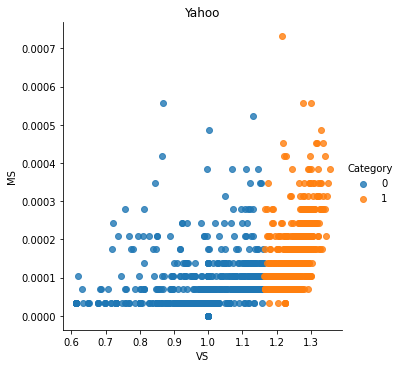

In [29]:
ed.perform_clustering()

In [30]:
f1_score = ed.compute_best_accuracy(time_series[:, 2])
print(f1_score)

0.009441384736428091


In [ ]:
print(ed.candidate_scores[826], ed.candidate_scores[827])

In [ ]:
total_f1_score = 0
total_examined = 56

for i in range(1, 56):
    try:
        time_series = pd.read_csv(
            '/home/szamani/PycharmProjects/anomaly-detection/dataset/concepts/sensor/light-anomaly/{}.csv'.format(i),
            converters={
                'time': int,
                'light': float
            })
    except:
        continue

    # print(time_series.head(100))
    time_series = np.array(time_series.values)

    ed = ErrorDetection(time_series)

    ed.compute_inn(time_series, 4)
    ed.compute_inn(time_series, 515)
    print(ed.standardize_time_series())

    # in the paper
    anomaly_score = ed.compute_anomaly_score(time_series[:, 1])
    mad = ed.compute_median_absolute_deviation(anomaly_score)
    candidate_points = [i for i in range(2, len(time_series)) if ed.compute_median_absolute_deviation(
        time_series[i - 2:i + 1, 1]) > mad]

    ed.compute_scores(candidate_points)

    ed.evaluate_scores()

    ed.perform_clustering()

    f1_score = ed.compute_best_accuracy(time_series[:, 2])

    if not f1_score:
        total_examined -= 1
        continue

    total_f1_score += f1_score

    break

print(total_f1_score / total_examined)
